<a href="https://colab.research.google.com/github/Tlen33/Forward-and-Convolutional-Neural-Networks-for-Audio-Signal-Processing/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Подключение библиотек

import os
import librosa
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import files
from tensorflow.keras.utils import to_categorical

In [ ]:
# Подключение диска

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Распаковка архива

!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/genres.zip'
genres = os.listdir('genres')

In [ ]:
# Функция параметризации аудио

def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  rmse = np.mean(librosa.feature.rms(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  for e in mfcc:
    out.append(np.mean(e))
  for e in chroma_stft:
    out.append(np.mean(e))
  
  return out

In [ ]:
# Формируем обучающую выборку

X_train = []
Y_train = []
curr_time = time.time()

for i in range(len(genres)):
  g = genres[i]
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    X_train.append(out)
    Y_train.append(to_categorical(i, len(genres)))

  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр reggae готов -> 44c
Жанр classical готов -> 44c
Жанр country готов -> 44c
Жанр rock готов -> 44c
Жанр hiphop готов -> 43c
Жанр disco готов -> 43c
Жанр pop готов -> 43c
Жанр blues готов -> 44c
Жанр metal готов -> 43c
Жанр jazz готов -> 43c


In [ ]:
# Создаём backup обучающей выборки

X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Номируем X_train

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train_class = np.argmax(Y_train, axis=1)

In [ ]:
# Разделение выборки на обучающую и проверочную

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 2.1109 - accuracy: 0.2611 - val_loss: 1.8821 - val_accuracy: 0.3600
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.7858 - accuracy: 0.3778 - val_loss: 1.6854 - val_accuracy: 0.3700
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.6333 - accuracy: 0.4233 - val_loss: 1.5642 - val_accuracy: 0.3800
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.5324 - accuracy: 0.4467 - val_loss: 1.4789 - val_accuracy: 0.4100
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.4556 - accuracy: 0.4767 - val_loss: 1.4141 - val_accuracy: 0.4400
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 1.3938 - accuracy: 0.5233 - val_loss: 1.3672 - val_accuracy: 0.4700
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.3419 - accuracy: 0.5478 - val_loss: 1.3211 - val_accuracy: 0.5000
Epoch 8/200
4

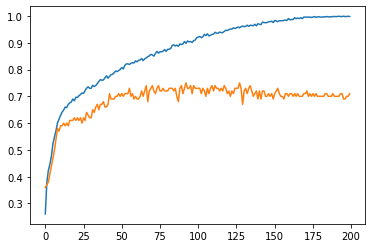

In [ ]:
# Нейронка

indexes = range(0,37)

model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(len(genres), activation='softmax'))
model.compile(optimizer=RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=200, batch_size=20, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Полносвязная сеть.
Точность на обучающей и проверочной выборках - 0.9978 / 0.7100.
Сеть быстро обучается, хорошая точность по проверочной выборке, можно доработать.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/600
45/45 [==============================] - 1s 5ms/step - loss: 2.4813 - accuracy: 0.0344 - val_loss: 2.4438 - val_accuracy: 0.0500
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 2.4176 - accuracy: 0.0511 - val_loss: 2.3871 - val_accuracy: 0.1100
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3616 - accuracy: 0.0656 - val_loss: 2.3357 - val_accuracy: 0.1200
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3112 - accuracy: 0.0900 - val_loss: 2.2915 - val_accuracy: 0.1400
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2659 - accuracy: 0.1233 - val_loss: 2.2521 - val_accuracy: 0.1600
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2250 - accuracy: 0.1544 - val_loss: 2.2160 - val_accuracy: 0.1500
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 2.1868 - accuracy: 0.1789 - val_loss: 2.1847 - val_accuracy: 0.1900
Epoch 8/600
4

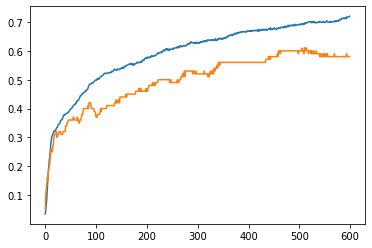

In [ ]:
# Простая сеть: один скрытый слой и 10 нейронов

input1 = Input((37,))

x1 = Dense(10, activation="elu")(input1)
x1 = Dense(10, activation="elu")(x1)

x = Dense(10, activation='elu')(x1)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=600, batch_size=20, validation_data=(X_test, y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Простая сеть с 1 Dense слоем.
Точность на обучающей и проверочной выборках - 0.7200 / 0.5800.
Сеть быстро обучается, плохая точность по проверочной выборке.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
45/45 [==============================] - 1s 12ms/step - loss: 2.1854 - accuracy: 0.2567 - val_loss: 2.0841 - val_accuracy: 0.2700
Epoch 2/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.9658 - accuracy: 0.3578 - val_loss: 1.9142 - val_accuracy: 0.3300
Epoch 3/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.8132 - accuracy: 0.3711 - val_loss: 1.7969 - val_accuracy: 0.3400
Epoch 4/1000
45/45 [==============================] - 0s 9ms/step - loss: 1.7062 - accuracy: 0.3878 - val_loss: 1.7025 - val_accuracy: 0.3600
Epoch 5/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.6234 - accuracy: 0.4244 - val_loss: 1.6255 - val_accuracy: 0.3700
Epoch 6/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.5550 - accuracy: 0.4344 - val_loss: 1.5660 - val_accuracy: 0.3800
Epoch 7/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.4955 - accuracy: 0.4544 - val_loss: 1.5118 - val_accuracy: 0.4100
Epoch

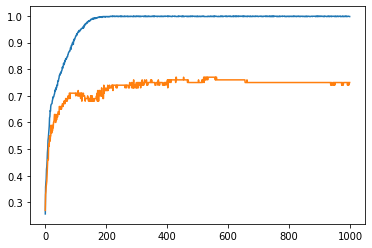

In [ ]:
# Сложная сеть: 5 слоёв по 100-1000 нейронов

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dense(100, activation="elu")(input1)
x1 = Dense(100, activation="elu")(x1)

x2 = Dense(300, activation="elu")(input1)
x2 = Dense(300, activation="softmax")(x2)

x3 = Dense(500, activation="elu")(input1)
x3 = Dense(500, activation="softmax")(x3)

x4 = Dense(700, activation="softmax")(input1)

x5 = Dense(900, activation="softmax")(input1)

x = concatenate([x1, x2, x3, x4, x5])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=20, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями.
Точность на обучающей и проверочной выборках - 0.9978 / 0.7500.
Сеть быстро обучается, хорошая точность по проверочной выборке, можно улучшить результат.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
45/45 [==============================] - 2s 12ms/step - loss: 2.2185 - accuracy: 0.2133 - val_loss: 2.1012 - val_accuracy: 0.3600
Epoch 2/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.9983 - accuracy: 0.3600 - val_loss: 1.9109 - val_accuracy: 0.3600
Epoch 3/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.8410 - accuracy: 0.3622 - val_loss: 1.7725 - val_accuracy: 0.3300
Epoch 4/1000
45/45 [==============================] - 0s 9ms/step - loss: 1.7238 - accuracy: 0.3733 - val_loss: 1.6706 - val_accuracy: 0.3600
Epoch 5/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.6312 - accuracy: 0.3844 - val_loss: 1.5986 - val_accuracy: 0.3800
Epoch 6/1000
45/45 [==============================] - 0s 9ms/step - loss: 1.5661 - accuracy: 0.4222 - val_loss: 1.5396 - val_accuracy: 0.3900
Epoch 7/1000
45/45 [==============================] - 0s 8ms/step - loss: 1.5105 - accuracy: 0.4467 - val_loss: 1.4901 - val_accuracy: 0.3900
Epoch

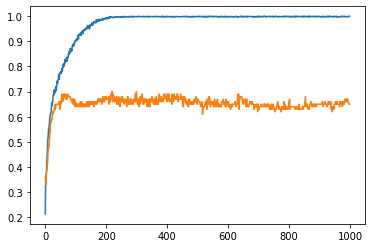

In [ ]:
# Сложная сеть: слои Dropout

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dropout(0.2)(x1)
x1 = Dense(100, activation="elu")(input1)
x1 = Dense(100, activation="elu")(x1)

x2 = Dropout(0.2)(x2)
x2 = Dense(300, activation="elu")(input1)
x2 = Dense(300, activation="softmax")(x2)

x3 = Dense(500, activation="elu")(input1)
x3 = Dense(500, activation="softmax")(x3)

x4 = Dense(700, activation="softmax")(input1)

x5 = Dense(900, activation="softmax")(input1)

x = concatenate([x1, x2, x3, x4, x5])

x = Dense(64, activation='elu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=20, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями + добавлены слои Dropout.
Точность на обучающей и проверочной выборках - 1.0000 / 0.6500.
Сеть быстро обучается, плохая точность по проверочной выборке.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
45/45 [==============================] - 3s 19ms/step - loss: 1.7597 - accuracy: 0.4056 - val_loss: 2.2876 - val_accuracy: 0.1400
Epoch 2/1000
45/45 [==============================] - 1s 12ms/step - loss: 1.3104 - accuracy: 0.5289 - val_loss: 2.2756 - val_accuracy: 0.1700
Epoch 3/1000
45/45 [==============================] - 1s 12ms/step - loss: 1.1219 - accuracy: 0.6244 - val_loss: 2.2619 - val_accuracy: 0.1800
Epoch 4/1000
45/45 [==============================] - 1s 12ms/step - loss: 1.0089 - accuracy: 0.6611 - val_loss: 2.2317 - val_accuracy: 0.1800
Epoch 5/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.9332 - accuracy: 0.6856 - val_loss: 2.1994 - val_accuracy: 0.1900
Epoch 6/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.8787 - accuracy: 0.7122 - val_loss: 2.1705 - val_accuracy: 0.2300
Epoch 7/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.8034 - accuracy: 0.7300 - val_loss: 2.0868 - val_accuracy: 0.2200

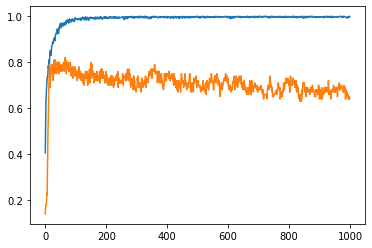

In [ ]:
# Сложная сеть: слои BatchNormalization

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dropout(0.2)(x1)
x1 = Dense(100, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(100, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dropout(0.2)(x2)
x2 = Dense(300, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(300, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(500, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(500, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(700, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(900, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x = concatenate([x1, x2, x3, x4, x5])

x = BatchNormalization()(x)
x = Dense(64, activation='elu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=20, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями + добавлены слои Dropout + добавлены слои BatchNormalization.
Точность на обучающей и проверочной выборках - 0.9978 / 0.6400.
Сеть обучается медленнее предыдущих, плохая точность по проверочной выборке.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
45/45 [==============================] - 3s 19ms/step - loss: 9.0707 - accuracy: 0.1500 - val_loss: 8.4147 - val_accuracy: 0.2500
Epoch 2/1000
45/45 [==============================] - 1s 12ms/step - loss: 6.0134 - accuracy: 0.2667 - val_loss: 5.3722 - val_accuracy: 0.3300
Epoch 3/1000
45/45 [==============================] - 1s 12ms/step - loss: 4.9713 - accuracy: 0.3067 - val_loss: 5.3448 - val_accuracy: 0.3300
Epoch 4/1000
45/45 [==============================] - 1s 12ms/step - loss: 4.8267 - accuracy: 0.3322 - val_loss: 3.9953 - val_accuracy: 0.3600
Epoch 5/1000
45/45 [==============================] - 1s 12ms/step - loss: 4.1757 - accuracy: 0.3644 - val_loss: 3.2300 - val_accuracy: 0.3400
Epoch 6/1000
45/45 [==============================] - 1s 13ms/step - loss: 3.8328 - accuracy: 0.3689 - val_loss: 2.7323 - val_accuracy: 0.3900
Epoch 7/1000
45/45 [==============================] - 1s 12ms/step - loss: 3.8271 - accuracy: 0.3533 - val_loss: 3.6806 - val_accuracy: 0.3400

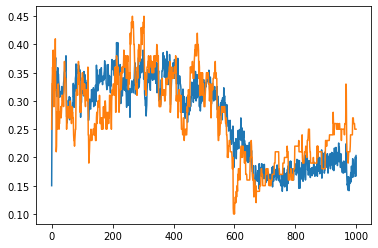

In [ ]:
# Меняем внутренние активационные функции, варианты: relu, elu, linear

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dropout(0.2)(x1)
x1 = Dense(100, activation="relu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dropout(0.2)(x2)
x2 = Dense(300, activation="relu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(300, activation="linear")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(500, activation="relu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(500, activation="linear")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(700, activation="linear")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(900, activation="linear")(input1)
x5 = BatchNormalization()(x5)

x = concatenate([x1, x2, x3, x4, x5])

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='linear')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=20, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями + добавлены слои Dropout + добавлены слои BatchNormalization + поменял активационные функции elu на relu, softmax на linear.
Точность на обучающей и проверочной выборках - 0.2033 / 0.2500.
Крайне низкая точность и необычный график.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
90/90 [==============================] - 4s 13ms/step - loss: 7.3081 - accuracy: 0.2100 - val_loss: 4.2318 - val_accuracy: 0.3000
Epoch 2/1000
90/90 [==============================] - 1s 10ms/step - loss: 5.0820 - accuracy: 0.3044 - val_loss: 3.9995 - val_accuracy: 0.3300
Epoch 3/1000
90/90 [==============================] - 1s 10ms/step - loss: 4.6488 - accuracy: 0.3156 - val_loss: 3.6258 - val_accuracy: 0.3200
Epoch 4/1000
90/90 [==============================] - 1s 10ms/step - loss: 4.4941 - accuracy: 0.3467 - val_loss: 3.8280 - val_accuracy: 0.3300
Epoch 5/1000
90/90 [==============================] - 1s 10ms/step - loss: 4.1160 - accuracy: 0.3433 - val_loss: 3.5660 - val_accuracy: 0.2400
Epoch 6/1000
90/90 [==============================] - 1s 10ms/step - loss: 3.7918 - accuracy: 0.2978 - val_loss: 3.0876 - val_accuracy: 0.2900
Epoch 7/1000
90/90 [==============================] - 1s 11ms/step - loss: 3.9267 - accuracy: 0.3022 - val_loss: 3.0865 - val_accuracy: 0.2700

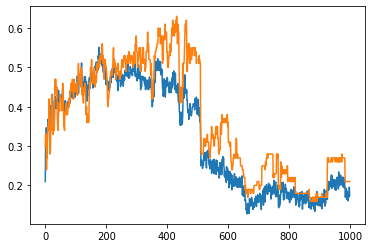

In [ ]:
# batch_size = 10

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dropout(0.2)(x1)
x1 = Dense(100, activation="relu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dropout(0.2)(x2)
x2 = Dense(300, activation="relu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(300, activation="linear")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(500, activation="relu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(500, activation="linear")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(700, activation="linear")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(900, activation="linear")(input1)
x5 = BatchNormalization()(x5)

x = concatenate([x1, x2, x3, x4, x5])

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='linear')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=10, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями, добавлены слои Dropout, добавлены слои BatchNormalization, поменял активационные функции elu на relu, softmax на linear, batch_size=10.
Точность на обучающей и проверочной выборках - 0.1744 / 0.2100.
Крайне низкая точность и необычный график.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
9/9 [==============================] - 2s 59ms/step - loss: 10.6131 - accuracy: 0.1222 - val_loss: 9.3998 - val_accuracy: 0.1800
Epoch 2/1000
9/9 [==============================] - 0s 27ms/step - loss: 8.8319 - accuracy: 0.2178 - val_loss: 8.0924 - val_accuracy: 0.2100
Epoch 3/1000
9/9 [==============================] - 0s 24ms/step - loss: 7.4472 - accuracy: 0.2856 - val_loss: 6.8585 - val_accuracy: 0.2700
Epoch 4/1000
9/9 [==============================] - 0s 23ms/step - loss: 6.5633 - accuracy: 0.3056 - val_loss: 5.3193 - val_accuracy: 0.2700
Epoch 5/1000
9/9 [==============================] - 0s 24ms/step - loss: 5.3322 - accuracy: 0.3433 - val_loss: 4.7842 - val_accuracy: 0.2700
Epoch 6/1000
9/9 [==============================] - 0s 24ms/step - loss: 4.7589 - accuracy: 0.3444 - val_loss: 4.2592 - val_accuracy: 0.3100
Epoch 7/1000
9/9 [==============================] - 0s 25ms/step - loss: 4.1641 - accuracy: 0.3389 - val_loss: 3.7826 - val_accuracy: 0.2900
Epoch 8/1000

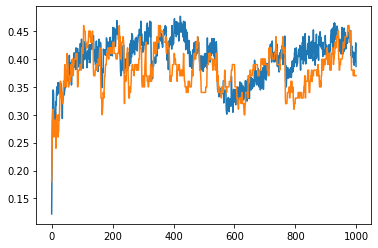

In [ ]:
# batch_size = 100

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dropout(0.2)(x1)
x1 = Dense(100, activation="relu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dropout(0.2)(x2)
x2 = Dense(300, activation="relu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(300, activation="linear")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(500, activation="relu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(500, activation="linear")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(700, activation="linear")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(900, activation="linear")(input1)
x5 = BatchNormalization()(x5)

x = concatenate([x1, x2, x3, x4, x5])

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='linear')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=100, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями, добавлены слои Dropout, добавлены слои BatchNormalization, поменял активационные функции elu на relu, softmax на linear, batch_size=100.
Точность на обучающей и проверочной выборках - 0.3867 / 0.3700.
Крайне низкая точность и необычный график.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 7.7439 - accuracy: 0.1867 - val_loss: 7.9787 - val_accuracy: 0.2200
Epoch 2/1000
1/1 [==============================] - 0s 151ms/step - loss: 7.4044 - accuracy: 0.2089 - val_loss: 7.4256 - val_accuracy: 0.2300
Epoch 3/1000
1/1 [==============================] - 0s 154ms/step - loss: 7.1967 - accuracy: 0.2133 - val_loss: 6.7748 - val_accuracy: 0.2200
Epoch 4/1000
1/1 [==============================] - 0s 157ms/step - loss: 6.8067 - accuracy: 0.2222 - val_loss: 6.4420 - val_accuracy: 0.2300
Epoch 5/1000
1/1 [==============================] - 0s 149ms/step - loss: 6.2756 - accuracy: 0.2533 - val_loss: 6.1758 - val_accuracy: 0.2500
Epoch 6/1000
1/1 [==============================] - 0s 166ms/step - loss: 6.0703 - accuracy: 0.2789 - val_loss: 6.0316 - val_accuracy: 0.2500
Epoch 7/1000
1/1 [==============================] - 0s 165ms/step - loss: 5.4315 - accuracy: 0.2667 - val_loss: 5.8753 - val_accuracy: 0.2400
Epoch 8/1

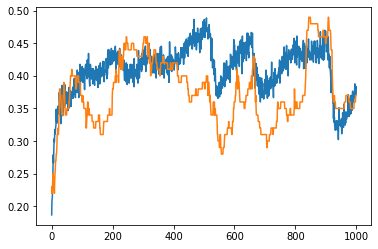

In [ ]:
# batch_size = 1000

indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dropout(0.2)(x1)
x1 = Dense(100, activation="relu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(100, activation="relu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dropout(0.2)(x2)
x2 = Dense(300, activation="relu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(300, activation="linear")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(500, activation="relu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(500, activation="linear")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(700, activation="linear")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(900, activation="linear")(input1)
x5 = BatchNormalization()(x5)

x = concatenate([x1, x2, x3, x4, x5])

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='linear')(x)

model = Model(input1, x)
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train[:, indexes], y_train, epochs=1000, batch_size=1000, validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# Вывод

Сложная сеть с 5ю отдельными слоями, добавлены слои Dropout, добавлены слои BatchNormalization, поменял активационные функции elu на relu, softmax на linear, batch_size=1000.
Точность на обучающей и проверочной выборках - 0.3833 / 0.3700
Крайне низкая точность и необычный график